<h2 align=center>Clasificación de pacientes con tumores y sin tumores </h2>

#1.Importación de librerías

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

#2.Montar el drive

In [14]:
# Necesitaremos montar un disco usando los siguientes comandos:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3.Definir la ruta para cargar los archivos 

In [17]:
# Navegamos hasta el directorio My Drive para almacenar el conjunto de datos
%cd /content/drive/MyDrive/Proyecto_Inteligencia_Artificial_Original/Proyecto_Introducción_Inteligencia_Artificial_Aplicacion_Medica/Brain_MRI

/content/drive/MyDrive/Proyecto_Inteligencia_Artificial_Original/Proyecto_Introducción_Inteligencia_Artificial_Aplicacion_Medica/Brain_MRI


#4.Se cargan y exploran los datos

In [18]:
# Datos que contienen la ruta a Brain MRI y su máscara correspondiente, la columna mask, la etiqueta cero indica que no hay tumor y la etiqueta 1 nos dice que si hay tumor 
brain_df = pd.read_csv('data_mask.csv')

##4.1.Análisis exploratorio sobre los datos

Los datos para este trabajo fueron descargados desde https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [19]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [20]:
brain_df.head(5)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [21]:
brain_df.mask_path[1] # Ruta a la imagen de la MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [22]:
brain_df.image_path[1] # Ruta a la máscara 

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [23]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [24]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [25]:
#Dataframe con las imagenes de pacientes con tumor
imagenes_con_tumor=brain_df["mask"]==1
imagenes_con_tumor=brain_df[imagenes_con_tumor]
imagenes_con_tumor=imagenes_con_tumor.reset_index()

In [26]:
#Dataframe con las imagenes de pacientes sin tumor
imagenes_sin_tumor=brain_df["mask"]==0
imagenes_sin_tumor=brain_df[imagenes_sin_tumor]
imagenes_sin_tumor=imagenes_sin_tumor.reset_index()

In [ ]:
# Se usa plotly para hacer un diagrama de barras
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

##4.2. Visualización de imágenes con y sin tumor

#4.2.1 Imagénes con tumor

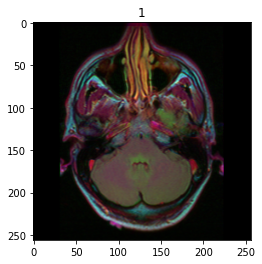

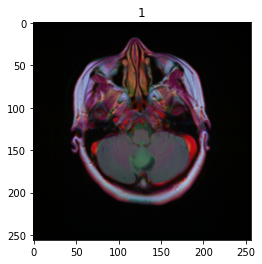

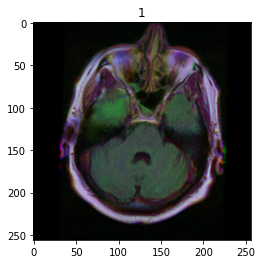

In [28]:
#Imagenes con tumor

for  i in range(3):
  img = cv2.imread(imagenes_con_tumor.image_path[i])
  plt.figure()
  plt.title(imagenes_con_tumor['mask'][i])
  plt.imshow(img)

#4.2.2 Imagénes sin tumor

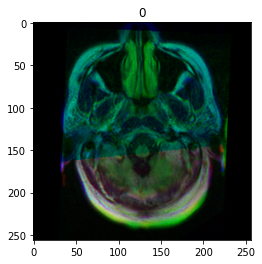

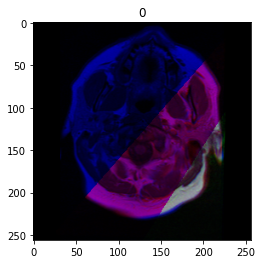

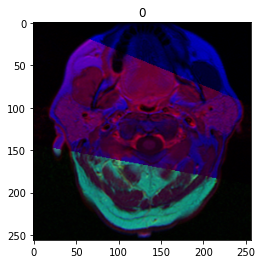

In [29]:
#Imagenes sin tumor

for  i in range(3):
  img = cv2.imread(imagenes_sin_tumor.image_path[i])
  plt.figure()
  plt.title(imagenes_sin_tumor['mask'][i])
  plt.imshow(img)

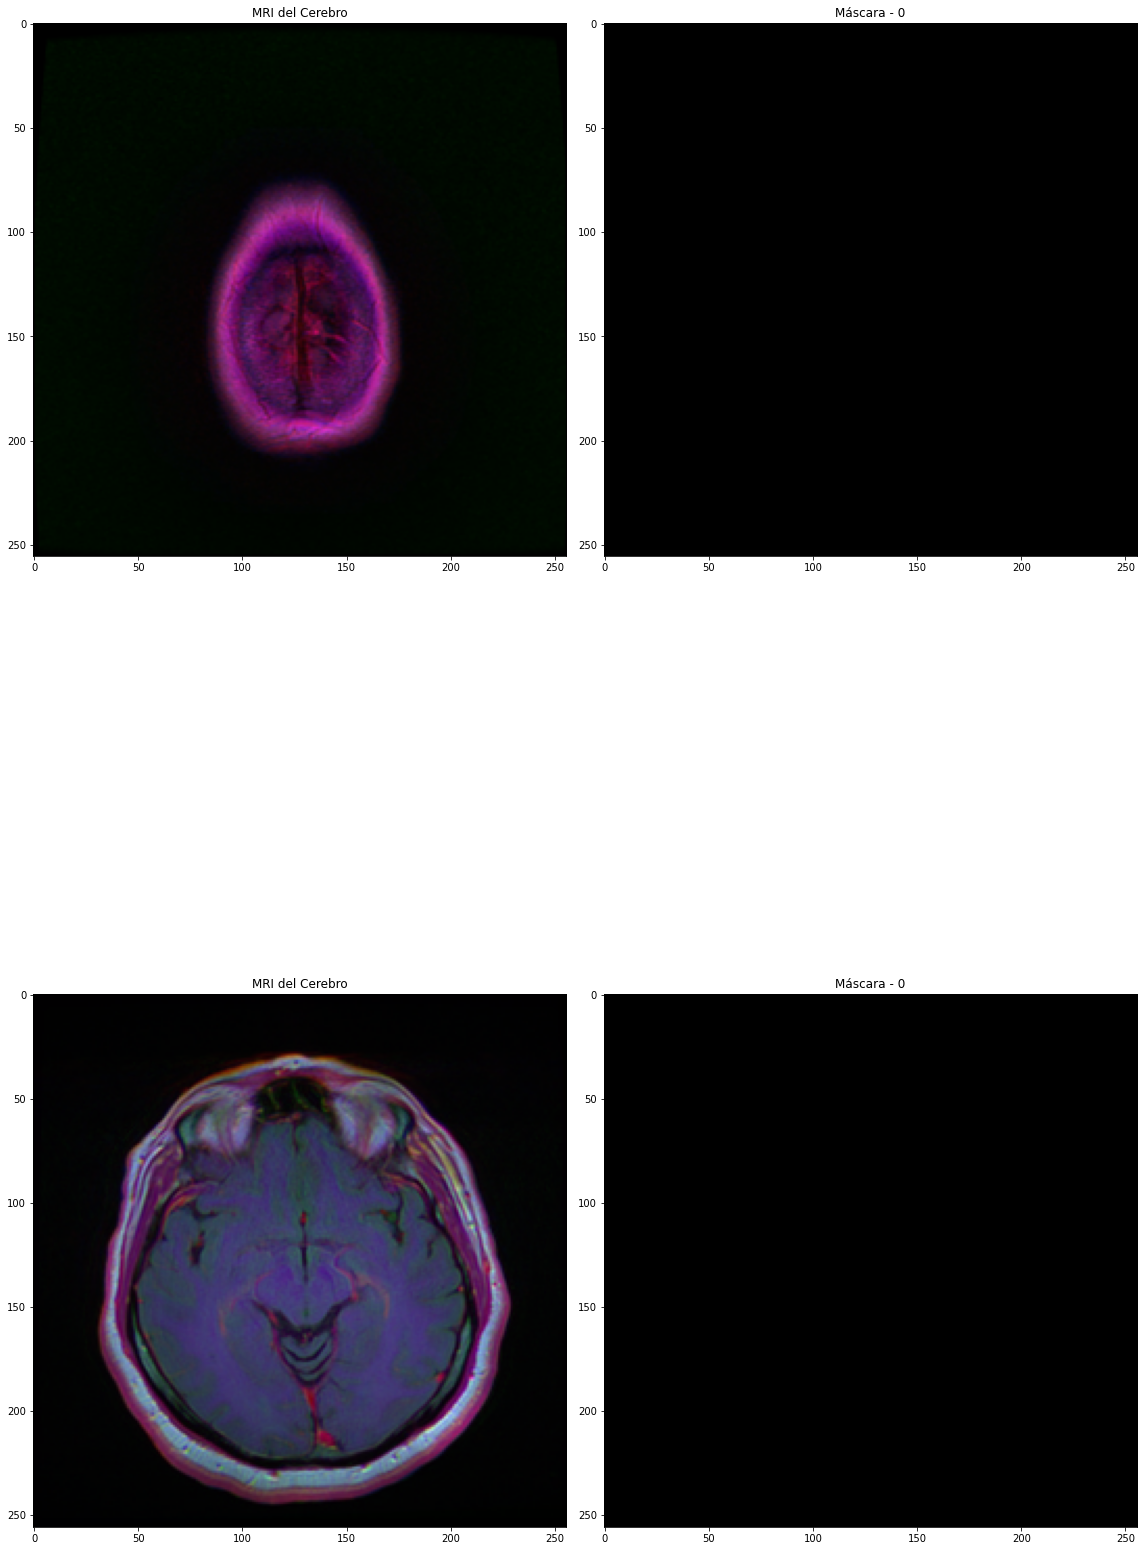

In [30]:
# Visualización básica Visualizaremos imágenes (MRI y Máscaras) en el dataset de forma separada
import random
fig, axs = plt.subplots(2,2, figsize=(16,32))
count = 0
for x in range(2):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostramos la MRI 
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostramos la máscara correspondiente 
  count += 1

fig.tight_layout()

#5.Construcción del modelo de clasificación

###5.1 Transformaciones en el conjunto de datos y división del conjunto de datos

In [31]:
# Eliminamos la columna de identificador del paciente
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [32]:
# Convertir los datos en la columna de máscara a formato de string, para usar el modo categórico
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [33]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [34]:
# Dividir los datos en entrenamiento y testing

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [35]:
# Creamos el generador de imágenes
from keras_preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

###5.2 Creación del generador de imágenes de training, validation y testing

In [36]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para imágenes de prueba
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


#6.Se instancia el modelo pre-entrenado Resnet50

Este modelo en su primera capa recibe imágenes de 256 por 256

In [37]:
# Obtenemos el modelo base de ResNet50 
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [38]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#7.Se congelan los pesos del modelo

In [39]:
# Congelamos los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

#8.Se construyen las capas top del modelo

In [40]:
# Agregamos una cabecera de clasificación a la base del modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Compilamos el modelo

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

#9.Generación de checkpoints

In [ ]:
# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye despues de 20 iteraciones
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

#10.Verificar disponibilidad de una GPU

In [ ]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

GPU encontrada: /device:GPU:0


#11.Entrenamiento con GPU

In [ ]:
import timeit

def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])
  return None

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')

Epoch 1/40
177/177 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6656
Epoch 1: val_loss improved from inf to 0.77131, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 789s 4s/step - loss: 0.8103 - accuracy: 0.6656 - val_loss: 0.7713 - val_accuracy: 0.3690
Epoch 2/40
177/177 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.7634
Epoch 2: val_loss improved from 0.77131 to 0.70806, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 47s 264ms/step - loss: 0.4702 - accuracy: 0.7634 - val_loss: 0.7081 - val_accuracy: 0.3690
Epoch 3/40
177/177 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.7967
Epoch 3: val_loss improved from 0.70806 to 0.65733, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 46s 260ms/step - loss: 0.4685 - accuracy: 0.7967 - val_loss: 0.6573 - val_accuracy: 0.6371
Epoch 4/40
177/177 

#12.Se guarda la arquitectura modelo entrenado 

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

#13.Evaluación de la calidad del modelo

In [42]:
# Cargamos el modelo entrenado
with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargar el modelo  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [43]:
# Hacemos la predicción
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 174s 5s/step


In [44]:
test_predict.shape

(576, 2)

In [45]:
test_predict

array([[9.9999857e-01, 1.4263410e-06],
       [9.9999452e-01, 5.5004680e-06],
       [6.5510349e-12, 1.0000000e+00],
       ...,
       [2.5529757e-15, 1.0000000e+00],
       [9.9999607e-01, 3.9293786e-06],
       [9.9591380e-01, 4.0861773e-03]], dtype=float32)

In [46]:
# Obtenemos la clase predicha a partir del modelo
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [47]:
predict

array(['0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1',
       '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0',
       '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1',
       '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0',
       '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1',
       '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0',
       '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1',
       '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1

In [48]:
# Dado que usamos el generador de prueba, se limita el número de imágenes a leer (predecir), debido al tamaño del lote, al mismo tamaño de la predicció
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [49]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9739583333333334

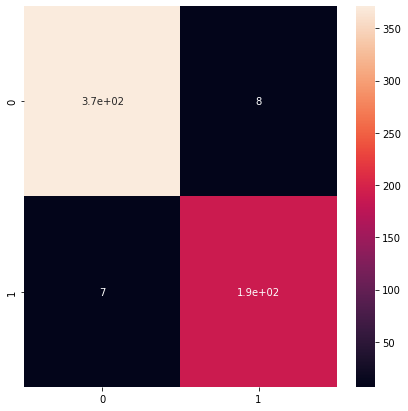

In [50]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
plt.show()

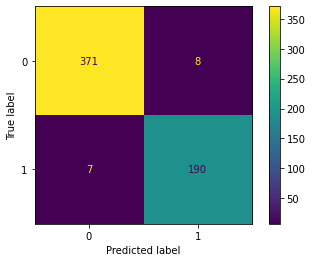

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
ConfusionMatrixDisplay.from_predictions(original, predict)
plt.show()

In [52]:
from sklearn.metrics import classification_report
#Obtenemos el reporte de métricas de clasificación 
report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       379
           1       0.96      0.96      0.96       197

   micro avg       0.97      0.97      0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
